# Introduction to NLP: Traditional approaches

# Naives Bayes and N-Grams for Text classification

The purpose of this notebook is to cover Naive Bayes and ngrams (some pretty classic techniques!) for text classification. We will be using some popular libraries like sklearn but we will implement some operation "manually", not using an existing package for educational purpose. *I will review and follow part of the exceptional NLP course by Rachel Thomas in Fastai, and most lines of code has been extracted or adapted from its notebook 3* (the link is down there) and 3b.

As in previous notebooks, this is a text classifier to identify fake tweets relatives to disasters. But we are not interested in the best model, we want to show you some traditional "tools" and methods to solve this kind of NLP problems and explain the concepts around them. 

Link to problem description in Kaggle: 

Link to code:
- https://github.com/fastai/course-nlp/blob/master/3-logreg-nb-imdb.ipynb
- https://github.com/lazyprogrammer/machine_learning_examples/blob/master/nlp_class/spam2.py

Link to blog post or aditional readings:
- https://sebastianraschka.com/Articles/2014_naive_bayes_1.html
- https://web.stanford.edu/class/cs124/lec/naivebayes.pdf


## Loading the libraries

In [33]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
#import seaborn as sn
from collections import Counter

%matplotlib inline

# Just once
#import nltk
#nltk.download('wordnet')
# Import the lemmatizer and the tokenizdr
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
# Import module to work with sparse matrixes
from scipy.sparse import csr_matrix

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc
from wordcloud import WordCloud

We set the variables for data location

In [2]:
# Global parameters relatives to file location and names
#root folder
root_folder='.'
#data_folder='.'
data_folder_name='.'
train_filename='train.csv'
# Variable for data directory
DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))

# Both train and test set are in the root data directory
train_path = DATA_PATH
test_path = DATA_PATH

#Relevant columns
TEXT_COLUMN = 'text'
TARGET_COLUMN = 'target'


### Loading the datasets

This notebook does not cover how to implement the best preprocessor to clean our tweets. So we are going to feed our model with the tweet as is or only removing no alphanumeric characters. For a better results, we should inspect the tweets and apply some cleaning removing useless words, mispelling words, maybe the URIs,... 

In [3]:
#Read the tweets of our train dataset
data = pd.read_csv(train_path+'\\'+train_filename)
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
#Extract only the text and target columns from our dataframe
data = data[[TEXT_COLUMN, TARGET_COLUMN]]
data.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


## Prepare the data to be used in our model

This notebook does not cover how to implement the best preprocessor to clean our tweets. So we are going to feed our model with the tweet as is or only removing no alphanumeric characters.

We split the train dataset into a train and validation dataset so we can evaluate the result and apply tricks like cross-validation. This job is done as in many others notebooks, using sklearn. 

In [5]:
# Split the dataset into a train and test dataset
X_train, X_test, y_train, y_test = train_test_split(data[TEXT_COLUMN], data[TARGET_COLUMN].values, 
                                                    test_size=0.20, random_state=0)

print('X Train Size:',X_train.shape)
print('X Test Size:',X_test.shape)

X Train Size: (6090,)
X Test Size: (1523,)


First, we show some tweets.

In [6]:
for doc in X_train[:10]:
    print(doc)

Ted Cruz fires back at Jeb &amp; Bush: ÛÏWe lose because of Republicans like Jeb &amp; Mitt.Û [Video] http://t.co/FgDEh56PLO
This is the first year the Forest Service spent more than half its annual budget on fighting fires. #climatechange http://t.co/D62zfZy0Mi
@lightseraphs pissed at you and could have their pikachu electrocute you and :\\\
I'm gonna fight Taylor as soon as I get there.
@NicolaClements4 IÛªm not sure that covering my head in wounds and scabs is the solution ;)
kabwandi_: Breaking news! Unconfirmed! I just heard a loud bang nearby. in what appears to be a blast of wind from my neighbour's ass.
The annihilation of Jeb Christie &amp; Kasich is less than 24 hours away..
Please God allow me at least one more full day...
Wtf this mom just drowned her child?!
@MayorofLondon pls reduce cyclist deaths with a compulsory highway code test as with EVERY OTHER VEHICLE that uses a road. #notrocketscience
@DoctorDryadma mass murder here we come


## Extracting the tokens from our text data

- **What is lemmatizer?**
For grammatical reasons, documents are going to use different forms of a word and there are families of derivationally related words with similar meanings, such as democracy, democratic, and democratization. In many situations, it seems as if it would be useful for a search for one of these words to return documents that contain another word in the set. So we can obtain a shorter vocabulary if we use the root "meaning" or word of these groups of word. Lemmatization and Stemming are two techniques to get the root word, but steemming is so crude and usually returns word with no meaning. Lemmatization is usually a better aproach.

We are going to use a very shor list of **Stop Words**. Stop words are generally the most common words in a language and they do not provide useful information about the context so we can remove them.
- **Use of stopwords**

Now it is time to convert a collection of text documents (our tweets) to a matrix of token/word counts. f you do not provide an a-priori dictionary and you do not use an analyzer that does some kind of feature selection then the number of features will be equal to the vocabulary size found by analyzing the data.


In [7]:
# Define the stopword list and create a Lemmatizer object
wordnet_lemmatizer = WordNetLemmatizer()
# Define the stop words extracted from a file with only 20-30 words to remove 
stopwords = set(w.rstrip() for w in open('NLP_short_stopwords.txt'))

Our tokenizer is very simple, apply lowercase to the text, remove very short words, lematize the words and finally remove the stopwords. As we said, we are not coding an expert parser for tweets.  

In [8]:
def my_tokenizer(s):
    s = s.lower() # downcase
    tokens = word_tokenize(s) # split string into words (tokens)
    tokens = [t for t in tokens if len(t) > 2] # remove short words, they're probably not useful
    tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens] # put words into base form
    tokens = [t for t in tokens if t not in stopwords] # remove stopwords
    return tokens


### Convert to tokens and create the vocabulary

First we need to create our vocabulary, the list of words/tokens we are expecting in our sentences. We tokenize all the tweets, save all the tokens and include them (not repeted) in the vocabulary. Our vocabulary is based on the train set (it is supossed that the test set is just for testing our model we do not know anything about it). But there would be probably new "tokens" in our test set (or in a future test text) so we include a token for "unknown" words, every new word will be replaced by this token. 

In [9]:
#We need to create our vocabulary. We tokenize every document, collect the tokens and extract the vocabulary.
all_tokens=[]
tokens=set()
for doc in X_train:
    # Extract tokens in doc
    doc_tokens=my_tokenizer(doc)
    # Store the tokens in two lists
    all_tokens.append(doc_tokens)
    tokens.update(set(doc_tokens))

# Create our dictionary or vocabulary to convert string/token to int
vocab={k:v for v, k in enumerate(tokens)}
# Add the token unknown to the dictionary
vocab['xxUNKxx']=len(vocab)
print('Vocabulary: ',len(vocab))

Vocabulary:  18434


### Create the term document matrix of our train and test data

Now we will create our own version of the Term Document Matrix. This is for two reasons:
- to understand what sklearn is doing underneath the hood
- to create something that will work with a fastai TextList

To create our term-document matrix, we will use counters and sparse matrices.

In [10]:
#Create the term document matrix. We are not going to use any package, just pass through the text and build our matrix.
def get_term_doc_matrix(documents,vocab):
    ''' Create and return the Term Document Matriz based on the documents and words provided as arguments'''
    j_indices = []
    indptr = []
    values = []
    indptr.append(0)

    for doc in documents:
        tokenstoi = [vocab[t] for t in doc]
        feature_counter = Counter(tokenstoi)
        j_indices.extend(feature_counter.keys())
        values.extend(feature_counter.values())
        indptr.append(len(j_indices))
    
    
     # for debugging purpose              
    #return (values, j_indices, indptr)
    return csr_matrix((values, j_indices, indptr),
                                    shape=(len(indptr) - 1, len(vocab)),
                                    dtype=int)

In [11]:
# Generate the Text Document Matrix
#v,j,i = get_term_doc_matrix(all_tokens,vocab)
trn_term_doc  = get_term_doc_matrix(all_tokens,vocab)

In [12]:
trn_term_doc.shape

(6090, 18434)

For the test dataset we need to check if the token is in the vocab, if not we replace it by the especial token for unknown words.

In [13]:
all_tokens=[]

for doc in X_test:
    doc_tokens=my_tokenizer(doc)
    all_tokens.append([t if t in vocab else 'xxUNKxx' for t in doc_tokens])


In [14]:
val_term_doc  = get_term_doc_matrix(all_tokens,vocab)

In [15]:
val_term_doc.shape

(1523, 18434)

## Naive Bayes

Naive Bayes classifiers, a family of classifiers that are based on the popular Bayes’ probability theorem, are known for creating simple yet well performing models, especially in the fields of document classification and disease prediction. The probabilistic model of naive Bayes classifiers is based on Bayes’ theorem, and the adjective naive comes from the assumption that the features in a dataset are mutually independent. In practice, the independence assumption is often violated, but naive Bayes classifiers still tend to perform very well under this unrealistic assumption [1]. Especially for small sample sizes, naive Bayes classifiers can outperform the more powerful alternatives.

Bayes’ rule can be written down in simple words as follows:

$posterior probability = \frac{\text{conditional probability}⋅\text{prior probability}}{\text{evidence}}$

In the context of pattern classification, the prior probabilities are also called class priors, which describe “the general probability of encountering a particular class.” In our case , the priors could be formulated as

$P(fake)="\text{the probability that any new message is a fake message}"$ and $P(real)=1−P(fake)$

And in context of text classification:

$P(fake) = \frac{\text{# of fake messages in training data}}{\text{# of all messages in training data}}$

For numerical stability purpose, we’re going to look at the log probability by taking the log of each side. Now we’re dealing with additions of log probabilities instead of multiplying many probabilities together! Since log has really nice properties (monotonicity being the key one), we can still take the highest score to be our prediction, i.e., we don’t have to “undo” the log!

**Explain**

We define the log-count ratio $r$ for each word $f$:

$r = \log \frac{\text{ratio of feature $f$ in positive documents}}{\text{ratio of feature $f$ in negative documents}}$

where ratio of feature $f$ in positive documents is the number of times a positive document has a feature divided by the number of positive documents.

In [16]:
# x is the term document matrix
x = trn_term_doc
# y is the target label
y = y_train
val_y = y_test

In [17]:
p1 = np.squeeze(np.asarray(x[y_train==1].sum(0)))
p0 = np.squeeze(np.asarray(x[y_train==0].sum(0)))

In [18]:
print(x[y_train==1].shape)
print(x[y_train==0].shape)

(2634, 18434)
(3456, 18434)


In [19]:
p1[:50]

array([ 4,  0,  0,  0,  0,  0,  1,  0,  1,  2,  1,  0,  0,  1,  1,  0,  1,
       16,  2,  1,  1,  2,  0,  0,  1,  0,  1,  1,  4,  1,  1,  1,  1,  0,
        0,  0,  1, 11,  2,  2,  0,  1,  0,  0,  1,  0,  1,  1,  0,  0],
      dtype=int32)

In order to avoid the problem of zero probabilities or division by zero, an additional smoothing term can be added to the  Bayes model. The most common variants of additive smoothing are the so-called Lidstone smoothing (α<1) and Laplace smoothing (α=1). So, we add 1 to the numerator and denominator.

In [20]:
pr1 = (p1+1) / ((y_train==1).sum() + 1)
pr0 = (p0+1) / ((y_train==0).sum() + 1)

In [21]:
r = np.log(pr1/pr0)
r

array([ 1.88095589, -0.4216292 , -0.4216292 , ..., -0.90713702,
        0.96466516,  0.27151798])

**Vocab most likely associated with positive/negative reviews**

In the next cells we will observe the vocabulary in the most positive and negative tweets.

In [22]:
biggest = np.argpartition(r, -10)[-10:]
smallest = np.argpartition(r, 10)[:10]

In [24]:
[list(vocab.keys())[list(vocab.values()).index(k)] for k in biggest]

['derailment',
 'investigator',
 'debris',
 'hiroshima',
 'migrant',
 'northern',
 'legionnaire',
 'mh370',
 'severe',
 'malaysia']

In [25]:
[list(vocab.keys())[list(vocab.values()).index(k)] for k in smallest]

['mayhem',
 'bag',
 'cat',
 'career',
 'ruin',
 'disney',
 'ebay',
 'lmao',
 'character',
 'crushed']

## Applying Naives Bayes

Now we can apply the 


In [26]:
(y_train==1).mean(), (y_train==0).mean()

(0.432512315270936, 0.5674876847290641)

In [27]:
b = np.log((y_train==1).mean() / (y_train==0).mean())

In [28]:
y_pred = (val_term_doc @ r + b) > 0

In [29]:
(y_pred==y_test).mean()

0.7636244254760342

## Evaluating the model

In [30]:
# Predicting the Test set results
#y_pred = model.predict(test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix: ',cm)
# Calculate the accuracy
acc = accuracy_score(y_test, y_pred)
print('Accuracy: ',acc)
# Calculate the points in the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
roc_auc= auc(fpr,tpr)

Confusion Matrix:  [[650 236]
 [124 513]]
Accuracy:  0.7636244254760342


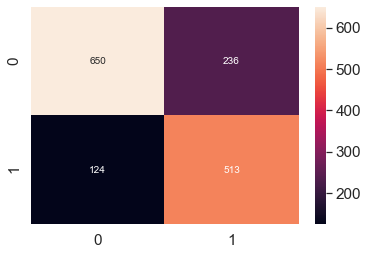

In [31]:
import seaborn as sn
# Create a dataframe with the confussion matrix values
df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))
# Plot the confussion matrix
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4) #for label size
sn.heatmap(df_cm, annot=True,fmt='.0f',annot_kws={"size": 10})# font size

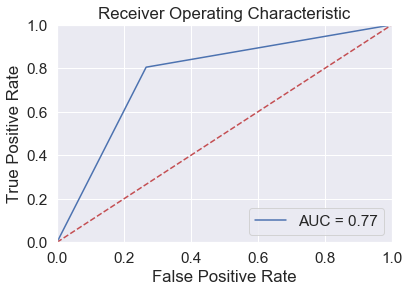

In [34]:
# ROC Curve
# plot no skill
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


### Data exploration: negative to positive ratios
I was curious about the ratio of times a given word appears in negative reviews to times it occurs in positive reviews. Bigger ratios (> 1) mean the word is indicative of a negative review, and smaller ratios (< 1) mean it is indicative of a positive review.

In [42]:
def neg_pos_given_word(word):
    print(p0[vocab[word]]/p1[vocab[word]])

In [46]:
neg_pos_given_word('real')

2.75


### Binarized Naive Bayes
Maybe it only matters whether a word is in the review or not (not the frequency of the word). So instead of the frequency of a token our term-document matrix will only contain 1 or 0 as values. This step simplifies the model and sometimes it can produce a better result.

In [35]:
# Create a term document matrix binarized, containing only 1 or 0 values if the word is in the text
x=trn_term_doc.sign()
y=y_train

In [36]:
x.todense()[:50,:50]

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

Repeat the same steps as before but using the binarized term document matrix

In [39]:
p1 = np.squeeze(np.asarray(x[y_train==1].sum(0)))
p0 = np.squeeze(np.asarray(x[y_train==0].sum(0)))

pr1 = (p1+1) / ((y_train==1).sum() + 1)
pr0 = (p0+1) / ((y_train==0).sum() + 1)

r = np.log(pr1/pr0)
b = np.log((y_train==1).mean() / (y_train==0).mean())

preds = (val_term_doc.sign() @ r + b) > 0

In [40]:
(preds==val_y).mean()

0.7760998030203545

we get a very litle improvement, now we can use some other machine learning algos to help us to improve our model.

## Logistic regression
Here is how we can fit logistic regression where the features are the **unigrams**.

In [41]:
from sklearn.linear_model import LogisticRegression

In [42]:
m = LogisticRegression(C=0.1, dual=True)
m.fit(x, y)
preds = m.predict(val_term_doc)
(preds==y_test).mean()

C:\Users\edumu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8076165462902167

We got an accuracy of 80% using Logistic Regression on the unigrams of our Naives Bayes approach.

## Trigrams with NB features
Our next model is a version of logistic regression with Naive Bayes features described here. For every document we compute binarized features as described above, but this time we use bigrams and trigrams too. Each feature is a log-count ratio. A logistic regression model is then trained to predict if it is real or fake.

### ngrams
An n-gram is a contiguous sequence of n items (where the items can be characters, syllables, or words). A 1-gram is a unigram, a 2-gram is a bigram, and a 3-gram is a trigram.

Here, we are referring to sequences of words. So examples of bigrams include "the dog", "said that", and "can't you".

In [56]:
min_n=1
max_n=3

j_indices = []
indptr = []
values = []
indptr.append(0)
num_tokens = len(vocab)

itongram = dict()
ngramtoi = dict()

for doc in X_train:
    doc_tokens=my_tokenizer(doc)
    tokenstoi = [vocab[t] for t in doc_tokens]
    feature_counter = Counter(tokenstoi)
    j_indices.extend(feature_counter.keys())
    values.extend(feature_counter.values())
    this_doc_ngrams = list()

    m = 0
    for n in range(min_n, max_n + 1):
        for k in range(len(vocab) - n + 1):
            ngram = tokenstoi[k: k + n]
            if str(ngram) not in ngramtoi:
                if len(ngram)==1:
                    num = ngram[0]
                    ngramtoi[str(ngram)] = num
                    itongram[num] = ngram
                else:
                    ngramtoi[str(ngram)] = num_tokens
                    itongram[num_tokens] = ngram
                    num_tokens += 1
            this_doc_ngrams.append(ngramtoi[str(ngram)])
            m += 1

    ngram_counter = Counter(this_doc_ngrams)
    j_indices.extend(ngram_counter.keys())
    values.extend(ngram_counter.values())
    indptr.append(len(j_indices))

In [58]:
# Create the trigrams document matrix
train_ngram_doc_matrix = csr_matrix((values, j_indices, indptr),
                                   shape=(len(indptr) - 1, len(ngramtoi)),
                                   dtype=int)

In [59]:
train_ngram_doc_matrix

<6090x118201 sparse matrix of type '<class 'numpy.int32'>'
	with 268987 stored elements in Compressed Sparse Row format>

In [60]:
len(ngramtoi), len(itongram)

(118201, 118201)

In [64]:
print(itongram[25000])
print(v[189], v[1301]

[17116, 2348]


NameError: name 'v' is not defined

### Create valid matrix

In [66]:
j_indices = []
indptr = []
values = []
indptr.append(0)

for doc in X_test:
    doc_tokens=my_tokenizer(doc)
    doc_tokens = [t if t in vocab else 'xxUNKxx' for t in doc_tokens]
    tokenstoi = [vocab[t] for t in doc_tokens]
    feature_counter = Counter(tokenstoi)
    j_indices.extend(feature_counter.keys())
    values.extend(feature_counter.values())
    this_doc_ngrams = list()

    m = 0
    for n in range(min_n, max_n + 1):
        for k in range(len(vocab) - n + 1):
            ngram = tokenstoi[k: k + n]
            if str(ngram) in ngramtoi:
                this_doc_ngrams.append(ngramtoi[str(ngram)])
            m += 1

    ngram_counter = Counter(this_doc_ngrams)
    j_indices.extend(ngram_counter.keys())
    values.extend(ngram_counter.values())
    indptr.append(len(j_indices))

In [67]:
valid_ngram_doc_matrix = csr_matrix((values, j_indices, indptr),
                                   shape=(len(indptr) - 1, len(ngramtoi)),
                                   dtype=int)

In [68]:
x=train_ngram_doc_matrix
y=y_train

In [69]:
x

<6090x118201 sparse matrix of type '<class 'numpy.int32'>'
	with 268987 stored elements in Compressed Sparse Row format>

In [70]:
k=118201

In [76]:
pos = (y == 1)[:k]
neg = (y == 0)[:k]
xx = x[:k]

In [77]:
xx

<6090x118201 sparse matrix of type '<class 'numpy.int32'>'
	with 268987 stored elements in Compressed Sparse Row format>

In [79]:
p0 = np.squeeze(np.array(xx[neg].sum(0)))
p1 = np.squeeze(np.array(xx[pos].sum(0)))

pr1 = (p1+1) / ((y==1).sum() + 1)
pr0 = (p0+1) / ((y==0).sum() + 1)

r = np.log(pr1/pr0)
b = np.log((y==1).mean() / (y==0).mean())
print('b: ',b)

b:  -0.2716082476207199


In [80]:
pre_preds = valid_ngram_doc_matrix @ r.T + b

In [81]:
pre_preds

array([-28.36480922,  -9.17880064,   2.03173239, ...,  13.46042239,
       -21.65151714,   9.0190975 ])

In [91]:
preds = pre_preds.T>0
(preds == y_test).mean()

0.8003939592908733

Now the results are better, but not significant

## Binarized Naive Bayes

In [94]:
trn_x_ngram_sgn = train_ngram_doc_matrix.sign()
val_x_ngram_sgn = valid_ngram_doc_matrix.sign()
xx = trn_x_ngram_sgn[:k]

p0 = np.squeeze(np.array(xx[neg].sum(0)))
p1 = np.squeeze(np.array(xx[pos].sum(0)))
pr1 = (p1+1) / ((y==1).sum() + 1)
pr0 = (p0+1) / ((y==0).sum() + 1)
r = np.log(pr1/pr0)
b = np.log((y==1).mean() / (y==0).mean())

pre_preds = val_x_ngram_sgn @ r.T + b
preds = pre_preds.T>0

(preds==y_test).mean()

0.7734734077478661

## Logistic Regression
Here we fit logistic regression where the features are the trigrams.
And we will use **CountVectorizer** to compare the results

In [96]:
veczr = CountVectorizer(ngram_range=(1,3), max_features=800000)

In [97]:
train_words = [[t for t in my_tokenizer(doc)] for doc in X_train]

In [99]:
test_words = [[t for t in my_tokenizer(doc)] for doc in X_test]

In [102]:
train_words[0]

['ted',
 'cruz',
 'fire',
 'back',
 'jeb',
 'amp',
 'bush',
 '\x89ûïwe',
 'lose',
 'because',
 'republican',
 'like',
 'jeb',
 'amp',
 'mitt.\x89û\x9d',
 'video',
 'http',
 '//t.co/fgdeh56plo']

In [103]:
%%time
train_ngram_doc = veczr.fit_transform(X_train)

Wall time: 1.15 s


In [104]:
train_ngram_doc

<6090x142879 sparse matrix of type '<class 'numpy.int64'>'
	with 259286 stored elements in Compressed Sparse Row format>

In [105]:
veczr.vocabulary_

{'ted': 116371,
 'cruz': 33940,
 'fires': 46451,
 'back': 14096,
 'at': 12507,
 'jeb': 70693,
 'amp': 7482,
 'bush': 20743,
 'ûïwe': 142775,
 'lose': 77321,
 'because': 15857,
 'of': 88700,
 'republicans': 102545,
 'like': 75620,
 'mitt': 81904,
 'video': 131769,
 'http': 59462,
 'co': 25931,
 'fgdeh56plo': 45756,
 'ted cruz': 116372,
 'cruz fires': 33943,
 'fires back': 46465,
 'back at': 14110,
 'at jeb': 12754,
 'jeb amp': 70694,
 'amp bush': 7549,
 'bush ûïwe': 20766,
 'ûïwe lose': 142776,
 'lose because': 77322,
 'because of': 15901,
 'of republicans': 89853,
 'republicans like': 102549,
 'like jeb': 75771,
 'amp mitt': 7733,
 'mitt video': 81905,
 'video http': 131795,
 'http co': 59463,
 'co fgdeh56plo': 27550,
 'ted cruz fires': 116374,
 'cruz fires back': 33944,
 'fires back at': 46466,
 'back at jeb': 14111,
 'at jeb amp': 12755,
 'jeb amp bush': 70695,
 'amp bush ûïwe': 7551,
 'bush ûïwe lose': 20767,
 'ûïwe lose because': 142777,
 'lose because of': 77323,
 'because of repu

In [106]:
val_ngram_doc = veczr.transform(X_test)

In [107]:
voc = veczr.get_feature_names()

In [110]:
voc[10000:10010]

['angry after odeon',
 'angry and',
 'angry and critical',
 'angry god',
 'angry god who',
 'angry http',
 'angry http co',
 'angry internally',
 'angry internally displaced',
 'angry mad']

### Logistic regression using ngrams from CountVectorizer

In [111]:
m = LogisticRegression(C=0.1, dual=True)
m.fit(train_ngram_doc, y_train);

preds = m.predict(val_ngram_doc)
(preds.T==y_test).mean()

C:\Users\edumu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8003939592908733

For Binarized Naive Bayes

In [112]:
m = LogisticRegression(C=0.1, dual=True)
m.fit(train_ngram_doc.sign(), y_train);

preds = m.predict(val_ngram_doc.sign())
(preds.T==y_test).mean()

0.7977675640183848

### Logistic regression using my ngrams 

In [113]:
m2 = LogisticRegression(C=0.0001, dual=True, max_iter=50000)
m2.fit(train_ngram_doc_matrix, y_train)

C:\Users\edumu\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=0.0001, class_weight=None, dual=True, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=50000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [114]:
preds = m2.predict(valid_ngram_doc_matrix)
(preds.T==y_test).mean()

0.41825344714379514